In [1]:
import os
!python.exe -m pip install --upgrade pip
!pip install emlearn

In [2]:
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


from imblearn.under_sampling import RandomUnderSampler


from joblib import parallel_backend


import tensorflow as tf
import tensorflow.keras.backend as K


import emlearn


import pickle


plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['lines.linewidth'] = 2

## Aux functions

In [3]:
def dataframe_shift(df, columns, windows):
    for i in range(1, windows):
        df = df.with_columns((pl.col(columns).shift(i)).name.prefix(f'prev_{i}_'))
    return df.drop_nulls()

In [4]:
def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

In [5]:
def get_mlp_keras(n_input, n_output):
    keras_mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_input,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(n_output, activation='softmax')
    ])
    
    keras_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[matthews_correlation_coefficient])

    return keras_mlp

In [6]:
def generate_models(n_input, n_output, light=False):
    # Remove MLP due to low performance and high computional resources
    # The code is present if anyone wants to explore further
    if light:
        models = [
            ('DecisionTreeClassifier', DecisionTreeClassifier(
            max_depth=128, max_features='sqrt', max_leaf_nodes=512, 
            random_state=42, class_weight='balanced')),
            ('RandomForestClassifier', RandomForestClassifier(n_estimators=32,
            max_depth=128, max_features='sqrt', max_leaf_nodes=512, 
            random_state=42, class_weight='balanced')),
            ('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=32,
            max_depth=128, max_features='sqrt', max_leaf_nodes=512, 
            random_state=42, class_weight='balanced')),
            ('Bagging', BaggingClassifier(n_estimators=32, max_features=0.1, random_state=42))
        ]
    else:
        models = [
            ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
            ('RandomForestClassifier', RandomForestClassifier(random_state=42,  class_weight='balanced')),
            ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42, class_weight='balanced')),
            ('Bagging', BaggingClassifier(random_state=42)),
            #('MLP (Keras)', get_mlp_keras(n_input, n_output))
        ]

    return models

In [7]:
def run_models(dfs, unique_labels, fr=None, n_components=0, light=False):
    rv = []
    for df_name, df in dfs:
        with parallel_backend('loky', n_jobs=-1):
            print(f'--- Dataset {df_name} ---')
            Y = df['Class'].to_numpy()
            X = df.drop(['Class', 'Time']).to_numpy()
            
            undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
            X, Y = undersample.fit_resample(X, Y)

            X_train, X_test, y_train, y_test = train_test_split(X, 
            Y, test_size=0.3, random_state=42, stratify=Y)

            # Feature Reduction
            if fr == 'PCA':
                pca = PCA(n_components=n_components)
                pca.fit(X_train)
                X_train = pca.transform(X_train)
                X_test = pca.transform(X_test)
            elif fr == 'NMF':
                nmf = NMF(n_components=n_components, init='nndsvda', solver='mu', max_iter=1000)
                nmf.fit(X_train)
                X_train = nmf.transform(X_train)
                X_test = nmf.transform(X_test)
            
            best = None
            print(f'{"":<22} Accuracy Precision Recall F1-score   MCC')
            # Generate models
            num_classes = len(unique_labels)
            models = generate_models(X_train.shape[1], num_classes, light=light)
            for name, clf in models:
                if name == 'MLP (Keras)':
                    y_train_keras = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
                    y_test_keras = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

                    clf.fit(X_train, y_train_keras,
                    batch_size=2048,
                    epochs=500,
                    verbose=0,
                    validation_data=(X_test, y_test_keras))

                    y_pred = clf.predict(X_test, verbose=0)
                    y_pred = np.argmax(y_pred, axis=1)
                else:
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                
                acc = accuracy_score(y_test, y_pred)
                mcc = matthews_corrcoef(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                print(f'{name:<22} {acc:>8.2f} {precision:>9.2f} {recall:>6.2f} {f1:>8.2f} {mcc:>5.2f}')

                if best is None:
                    best = (mcc, clf, name, y_test, y_pred)
                else:
                    if mcc > best[0]:
                        best = (mcc, clf, name, y_test, y_pred)
        _, clf, name, y_test, y_pred = best
        rv.append(clf)
        print(f'')
        print(f'Confusion Matrix for the best performing model: {name}')
        cf_matrix = confusion_matrix(y_test, y_pred)
        normalized_cf_matrix = cf_matrix / np.sum(cf_matrix)
        scaled_cf_matrix = normalized_cf_matrix * 8  # Scale to 100%
        
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=scaled_cf_matrix,
                                                     display_labels=unique_labels)
        cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
        plt.show()
        return rv

## Load Data

In [8]:
import os
import polars as pl

# Initialize variables to store global min and max values
global_min_x = float('inf')
global_max_x = float('-inf')
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_z = float('inf')
global_max_z = float('-inf')

# Initialize lists to store min and max values for averaging
min_x_list = []
max_x_list = []
min_y_list = []
max_y_list = []
min_z_list = []
max_z_list = []

# List to store dataframes
dfs = []

all_files = os.listdir('data/train')    
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))



for dataset in csv_files:
    df = pl.read_csv(f'data/train/{dataset}', separator=';').with_columns(
        pl.from_epoch('Time', time_unit='ms')
    )

    # Filter invalid reads
    df = df.filter((pl.col('Acc_X (mg)') > -5000) & (pl.col('Acc_X (mg)') < 5000))
    df = df.filter((pl.col('Acc_Y (mg)') > -5000) & (pl.col('Acc_Y (mg)') < 5000))
    df = df.filter((pl.col('Acc_Z (mg)') > -5000) & (pl.col('Acc_Z (mg)') < 5000))

    # Calculate min and max for each file
    min_acc_x = df['Acc_X (mg)'].min()
    max_acc_x = df['Acc_X (mg)'].max()
    min_acc_y = df['Acc_Y (mg)'].min()
    max_acc_y = df['Acc_Y (mg)'].max()
    min_acc_z = df['Acc_Z (mg)'].min()
    max_acc_z = df['Acc_Z (mg)'].max()
   
    print(f"{dataset}: Min_X={min_acc_x}, Max_X={max_acc_x}, Min_Y={min_acc_y}, Max_Y={max_acc_y}, Min_Z={min_acc_z}, Max_Z={max_acc_z}")

    # Update global min and max values
    global_min_x = min(global_min_x, min_acc_x)
    global_max_x = max(global_max_x, max_acc_x)
    global_min_y = min(global_min_y, min_acc_y)
    global_max_y = max(global_max_y, max_acc_y)
    global_min_z = min(global_min_z, min_acc_z)
    global_max_z = max(global_max_z, max_acc_z)

    # Append the values to the lists for averaging
    min_x_list.append(min_acc_x)
    max_x_list.append(max_acc_x)
    min_y_list.append(min_acc_y)
    max_y_list.append(max_acc_y)
    min_z_list.append(min_acc_z)
    max_z_list.append(max_acc_z)

    # Scale the ACC per file
    df = df.with_columns(
        pl.col('Acc_X (mg)').map_batches(lambda x: pl.Series(minmax_scale(x))),
        pl.col('Acc_Y (mg)').map_batches(lambda x: pl.Series(minmax_scale(x))),
        pl.col('Acc_Z (mg)').map_batches(lambda x: pl.Series(minmax_scale(x)))
    )

    
    
    # Resample the data
    df_resample = df.set_sorted('Time').group_by_dynamic('Time', every='1s').agg(
        pl.col('Acc_X (mg)').median(),
        pl.col('Acc_Y (mg)').median(),
        pl.col('Acc_Z (mg)').median(),
        pl.col('Temperature (C)').median(),
        pl.col('Class').mode().first()
    )
    dfs.append(df_resample)

df_mdn = pl.concat(dfs)

# Fix the class (class 99 becomes 7 due to keras limitations)
# df_mdn = df_mdn.with_columns(Class=pl.col('Class').replace([-1, 8, 9, 10, 11], [7, 7, 7, 7, 7]))

# Print the global min and max values
print(f"Global Min/Max for Acc_X (mg): Min = {global_min_x}, Max = {global_max_x}")
print(f"Global Min/Max for Acc_Y (mg): Min = {global_min_y}, Max = {global_max_y}")
print(f"Global Min/Max for Acc_Z (mg): Min = {global_min_z}, Max = {global_max_z}")

# Calculate and print the averaged min and max values for each axis
avg_min_x = sum(min_x_list) / len(min_x_list)
avg_max_x = sum(max_x_list) / len(max_x_list)
avg_min_y = sum(min_y_list) / len(min_y_list)
avg_max_y = sum(max_y_list) / len(max_y_list)
avg_min_z = sum(min_z_list) / len(min_z_list)
avg_max_z = sum(max_z_list) / len(max_z_list)

print(f"Averaged Min/Max for Acc_X (mg): Avg_Min = {avg_min_x}, Avg_Max = {avg_max_x}")
print(f"Averaged Min/Max for Acc_Y (mg): Avg_Min = {avg_min_y}, Avg_Max = {avg_max_y}")
print(f"Averaged Min/Max for Acc_Z (mg): Avg_Min = {avg_min_z}, Avg_Max = {avg_max_z}")



POS_02_EFFB68709EC6_2024-05-04T21.55.00+02.00_2__annotated_class_all.csv: Min_X=-2844, Max_X=4440, Min_Y=-2376, Max_Y=3040, Min_Z=-4192, Max_Z=2700
POS_02_EFFB68709EC6_2024-05-16T19.29.00+02.00_2__annotated_class_all.csv: Min_X=-2372, Max_X=4060, Min_Y=-4236, Max_Y=3880, Min_Z=-4476, Max_Z=2724
POS_03_F32F1EAC1A03_2024-05-09T10.04.00+02.00_2__annotated_class_all.csv: Min_X=-4584, Max_X=4392, Min_Y=-3676, Max_Y=3788, Min_Z=-4840, Max_Z=2840
POS_03_F32F1EAC1A03_2024-05-13T16.08.00+02.00_3__annotated_class_all.csv: Min_X=-3852, Max_X=3960, Min_Y=-3300, Max_Y=2344, Min_Z=-3532, Max_Z=2500
POS_04_D25FB6929885_2024-05-07T18.41.00+02.00_2__annotated_class_all.csv: Min_X=-4968, Max_X=3920, Min_Y=-3984, Max_Y=2440, Min_Z=-4912, Max_Z=932
POS_04_D25FB6929885_2024-05-13T04.12.00+02.00_2__annotated_class_all.csv: Min_X=-2812, Max_X=3232, Min_Y=-3180, Max_Y=2968, Min_Z=-3344, Max_Z=416
POS_05_C93786F37B57_2024-04-26T11.51.00+02.00_2__annotated_class_all.csv: Min_X=-4300, Max_X=3600, Min_Y=-2628, Ma

## Class distribution

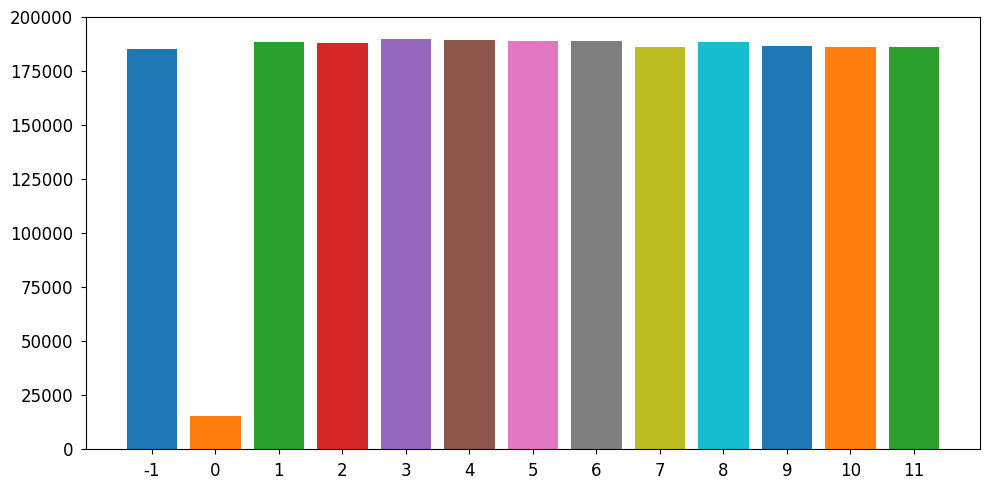

In [12]:
unique = df_mdn.unique(subset=['Class'], maintain_order=True)
unique_labels = sorted(unique['Class'].to_list())
unique = sorted(unique['Class'].to_list())

# Plot configuration
plt.figure(figsize=(10, 5))  # Adjust figure size (width stays the same, height is halved)
for label in unique:
    df_label = df_mdn.filter(pl.col('Class') == label)
    plt.bar([label], [df_label.shape[0]], width=0.8)

plt.xticks(unique, unique, fontsize=12)  # Increase font size for labels
plt.yticks(fontsize=12)  # Increase font size for y-axis ticks
plt.ylim(0, 200000)  # Limit y-axis to 175,000
plt.show()


## Reference models

--- Dataset AGG Median ---
                       Accuracy Precision Recall F1-score   MCC
DecisionTreeClassifier     0.30      0.31   0.30     0.30  0.24
RandomForestClassifier     0.47      0.47   0.47     0.46  0.42
ExtraTreesClassifier       0.47      0.47   0.47     0.47  0.43
Bagging                    0.21      0.21   0.21     0.21  0.15

Confusion Matrix for the best performing model: ExtraTreesClassifier


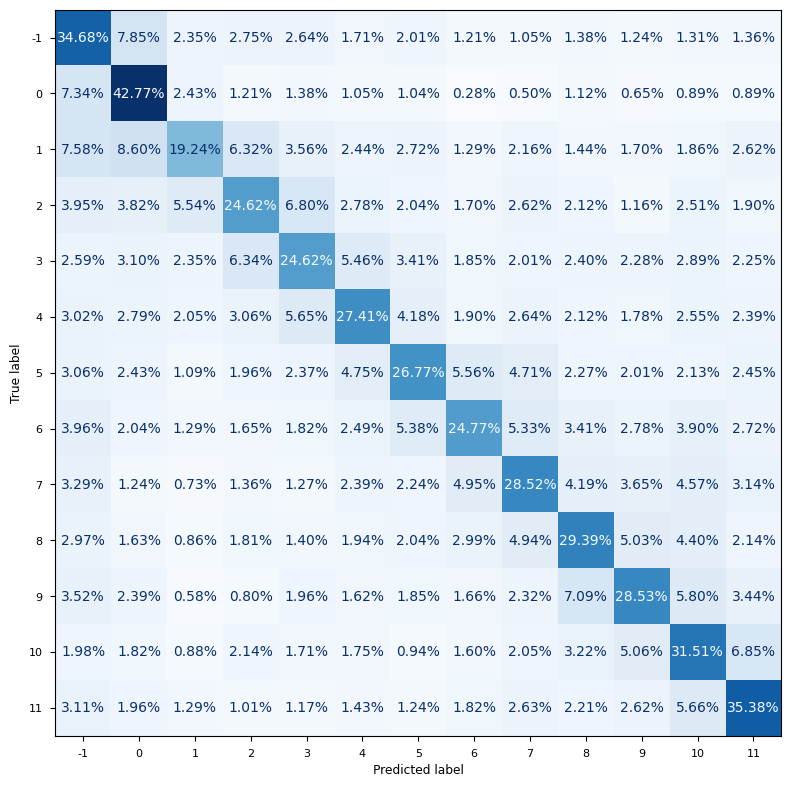

In [10]:
best_models = run_models([('AGG Median', df_mdn)], unique_labels, light=True)
# Store best model with EMLearn
cmodel = emlearn.convert(best_models[0], method='inline')
cmodel.save(file='models/emlearn/clf_agg_median.h', name='clf_agg_median')
# Store model to use internally
with open('models/pickle/clf_agg_median_light.pkl', 'wb') as f:
    pickle.dump(best_models[0], f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
best_models = run_models([('AGG Median', df_mdn)], unique_labels, light=False)
# Store model to use internally
with open('models/pickle/clf_agg_median.pkl', 'wb') as f:
    pickle.dump(best_models[0], f, protocol=pickle.HIGHEST_PROTOCOL)

--- Dataset AGG Median ---
                       Accuracy Precision Recall F1-score   MCC
DecisionTreeClassifier     0.56      0.56   0.56     0.56  0.53


KeyboardInterrupt: 

## Sequence Learning

In [ ]:
window = 120
df_roll_mdn = dataframe_shift(df_mdn, columns=['Acc_X (mg)', 'Acc_Y (mg)', 'Acc_Z (mg)', 'Temperature (C)'], windows=window)

In [ ]:
best_models = run_models([('Roll AGG Median', df_roll_mdn)], unique_labels, light=True)
# Store best model with EMLearn
# cmodel = emlearn.convert(best_models[0], method='inline')
# cmodel.save(file='models/emlearn/clf_roll_agg_median.h', name='clf_roll_agg_median')
# Store model to use internally
with open('models/pickle/clf_roll_agg_median_light.pkl', 'wb') as f:
    pickle.dump(best_models[0], f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
best_models = run_models([('Roll AGG Median', df_roll_mdn)], unique_labels, light=False)
# Store model to use internally
with open('models/pickle/clf_roll_agg_median.pkl', 'wb') as f:
    pickle.dump(best_models[0], f, protocol=pickle.HIGHEST_PROTOCOL) 

## False Positive Test

### Referece Models

In [ ]:
all_files = os.listdir('data/test')    
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

def minmax_scale_custom(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)

print(csv_files)
dfs = []
for dataset in csv_files:
    df = pl.read_csv(f'data/test/{dataset}',separator=';').with_columns(
    pl.from_epoch('Time', time_unit='ms'))
    
    # Filter invalid reads
    df = df.filter((pl.col('Acc_X (mg)') > -5000) & (pl.col('Acc_X (mg)') < 5000))
    df = df.filter((pl.col('Acc_Y (mg)') > -5000) & (pl.col('Acc_Y (mg)') < 5000))
    df = df.filter((pl.col('Acc_Z (mg)') > -5000) & (pl.col('Acc_Z (mg)') < 5000))

    # Calculate min and max for each file
    min_acc_x = df['Acc_X (mg)'].min()
    max_acc_x = df['Acc_X (mg)'].max()
    min_acc_y = df['Acc_Y (mg)'].min()
    max_acc_y = df['Acc_Y (mg)'].max()
    min_acc_z = df['Acc_Z (mg)'].min()
    max_acc_z = df['Acc_Z (mg)'].max()
   
    print(f"{dataset}: Min_X={min_acc_x}, Max_X={max_acc_x}, Min_Y={min_acc_y}, Max_Y={max_acc_y}, Min_Z={min_acc_z}, Max_Z={max_acc_z}")
    
    # Scale the ACC per file
    df = df.with_columns(
        pl.col('Acc_X (mg)').map_batches(lambda x: pl.Series(minmax_scale(x))),
        pl.col('Acc_Y (mg)').map_batches(lambda x: pl.Series(minmax_scale(x))),
        pl.col('Acc_Z (mg)').map_batches(lambda x: pl.Series(minmax_scale(x)))
    )

    # Resample the data
    df_resample = df.set_sorted('Time').group_by_dynamic('Time', every='1s').agg(
    pl.col('Acc_X (mg)').median(),
    pl.col('Acc_Y (mg)').median(),
    pl.col('Acc_Z (mg)').median(),
    pl.col('Temperature (C)').median(),
    pl.col('Class').mode().first()
    )
    dfs.append(df_resample)
df_mdn = pl.concat(dfs)

# Fix the class
# Fix the class (class 99 becomes 7 due to keras limitations)
# df_mdn = df_mdn.with_columns(Class=pl.col('Class').replace([-1, 8, 9, 10, 11], [7, 7, 7, 7, 7]))

In [ ]:
# Load reference models
all_files = os.listdir('models/pickle')    
pkl_files = list(filter(lambda f: f.endswith('.pkl'), all_files))
model_files = list(filter(lambda f: f.find('roll')<0, pkl_files))

models = []
for model_file in model_files:
    with open(f'models/pickle/{model_file}', 'rb') as f:
        clf = pickle.load(f)
        models.append((model_file, clf))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, matthews_corrcoef, f1_score, 
                             recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay)

y = df_mdn['Class'].to_numpy()
X = df_mdn.drop(['Class', 'Time']).to_numpy()

# Define the full range of labels from 0 to 7
full_labels = np.arange(-1, 12)
# full_labels = np.arange(0, 8)

for name, clf in models:
    y_pred = clf.predict(X)
    
    # Calculate metrics
    acc = accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    
    # Print metrics
    print(f'{name:<22} {acc:>8.2f} {precision:>9.2f} {recall:>6.2f} {f1:>8.2f} {mcc:>5.2f}')  
    print(f'')
    print(f'Confusion Matrix for the best performing model: {name}')
    
    # Compute confusion matrix including all labels
    cf_matrix = confusion_matrix(y, y_pred, labels=full_labels)
    
    # Normalize the confusion matrix if needed (row-wise)
    with np.errstate(invalid='ignore', divide='ignore'):
        cm_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
        cm_normalized[np.isnan(cm_normalized)] = 0  # Set NaNs to 0

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=full_labels)
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    plt.xticks(ticks=np.arange(len(full_labels)), labels=full_labels)
    plt.yticks(ticks=np.arange(len(full_labels)), labels=full_labels)
    plt.show()


### Sequence Models

In [ ]:
window = 120
df_roll_mdn = dataframe_shift(df_mdn, columns=['Acc_X (mg)', 'Acc_Y (mg)', 'Acc_Z (mg)', 'Temperature (C)'], windows=window)

In [ ]:
# Load reference models
all_files = os.listdir('models/pickle')    
pkl_files = list(filter(lambda f: f.endswith('.pkl'), all_files))
model_files = list(filter(lambda f: 'roll' in f, pkl_files))
print(model_files)

models = []
for model_file in model_files:
    with open(f'models/pickle/{model_file}', 'rb') as f:
        clf = pickle.load(f)
        models.append((model_file, clf))

In [ ]:
# Classify the files in the test folder
y = df_roll_mdn['Class'].to_numpy()
X = df_roll_mdn.drop(['Class', 'Time']).to_numpy()
print(models)

for name, model in models:
    y_pred = model.predict(X)            
    acc = accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    print(f'{name:<22} {acc:>8.2f} {precision:>9.2f} {recall:>6.2f} {f1:>8.2f} {mcc:>5.2f}')  
    print(f'')
    print(f'Confusion Matrix for the best performing model: {name}')
   
    # Generate the confusion matrix
    cf_matrix = confusion_matrix(y, y_pred)
    
    # Normalize the confusion matrix by rows (actual classes) so that each row sums to 1 (not 100)
    cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix with percentage format
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_normalized, display_labels=full_labels)
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    
    # Adjust the x and y ticks if needed
    plt.xticks(ticks=np.arange(len(full_labels)), labels=full_labels)
    plt.yticks(ticks=np.arange(len(full_labels)), labels=full_labels)
    
    # Show the plot
    plt.show()
